<!--BOOK_INFORMATION-->
<a href="https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv" target="_blank"><img align="left" src="data/cover.jpg" style="width: 76px; height: 100px; background: white; padding: 1px; border: 1px solid black; margin-right:10px;"></a>
*This notebook contains an excerpt from the book [Machine Learning for OpenCV](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv) by Michael Beyeler.
The code is released under the [MIT license](https://opensource.org/licenses/MIT),
and is available on [GitHub](https://github.com/mbeyeler/opencv-machine-learning).*

*Note that this excerpt contains only the raw code - the book is rich with additional explanations and illustrations.
If you find this content useful, please consider supporting the work by
[buying the book](https://www.packtpub.com/big-data-and-business-intelligence/machine-learning-opencv)!*

<!--NAVIGATION-->
< [Combining Decision Trees Into a Random Forest](10.02-Combining-Decision-Trees-Into-a-Random-Forest.ipynb) | [Contents](../README.md) | [Implementing AdaBoost](10.04-Implementing-AdaBoost.ipynb) >

# Using Random Forests for Face Recognition

A popular dataset that we haven't talked much about yet is the **Olivetti face dataset**.

The Olivetti face dataset was collected in 1990 by AT&T Laboratories Cambridge. The
dataset comprises facial images of 40 distinct subjects, taken at different times and under
different lighting conditions. In addition, subjects varied their facial expression
(open/closed eyes, smiling/not smiling) and their facial details (glasses/no glasses).

Images were then quantized to 256 grayscale levels and stored as unsigned 8-bit integers.
Because there are 40 distinct subjects, the dataset comes with 40 distinct target labels.
Recognizing faces thus constitutes an example of a **multiclass classification** task.

## Loading the dataset

Like many other classic datasets, the Olivetti face dataset can be loaded using scikit-learn:

In [1]:
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces()

In [2]:
X = dataset.data
y = dataset.target

Although the original images consisted of 92 x 112 pixel images, the version available
through scikit-learn contains images downscaled to 64 x 64 pixels.

To get a sense of the dataset, we can plot some example images. Let's pick eight indices
from the dataset in a random order:

In [3]:
import numpy as np
np.random.seed(21)
idx_rand = np.random.randint(len(X), size=8)

We can plot these example images using Matplotlib, but we need to make sure we reshape
the column vectors to 64 x 64 pixel images before plotting:

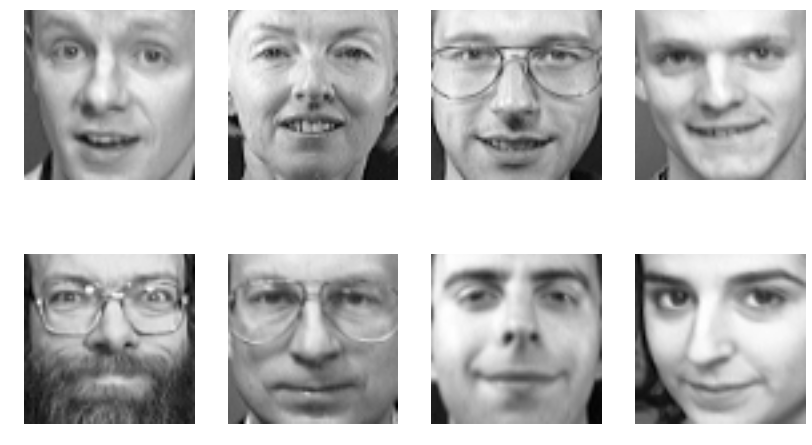

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14, 8))
for p, i in enumerate(idx_rand):
    plt.subplot(2, 4, p + 1)
    plt.imshow(X[i, :].reshape((64, 64)), cmap='gray')
    plt.axis('off')

You can see how all the faces are taken against a dark background and are upright. The
facial expression varies drastically from image to image, making this an interesting
classification problem. Try not to laugh at some of them!

## Preprocessing the dataset

Before we can pass the dataset to the classifier, we need to preprocess it following the best
practices from [Chapter 4](04.00-Representing-Data-and-Engineering-Features.ipynb), *Representing Data and Engineering Features*.

Specifically, we want to make sure that all example images have the same mean grayscale
level:

In [5]:
n_samples, n_features = X.shape
X -= X.mean(axis=0)

We repeat this procedure for every image to make sure the feature values of every data
point (that is, a row in `X`) are centered around zero:

In [6]:
X -= X.mean(axis=1).reshape(n_samples, -1)

The preprocessed data can be visualized using the preceding code:

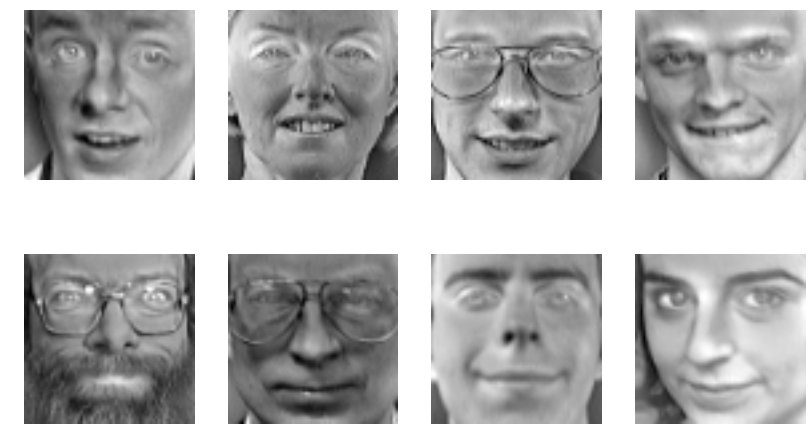

In [7]:
plt.figure(figsize=(14, 8))
for p, i in enumerate(idx_rand):
    plt.subplot(2, 4, p + 1)
    plt.imshow(X[i, :].reshape((64, 64)), cmap='gray')
    plt.axis('off')
plt.savefig('olivetti-pre.png')

## Training and testing the random forest

We continue to follow our best practice to split the data into training and test sets:

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=21
)

Then we are ready to apply a random forest to the data:

In [9]:
import cv2
rtree = cv2.ml.RTrees_create()

Here we want to create an ensemble with 50 decision trees:

In [10]:
num_trees = 50
eps = 0.01
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,
            num_trees, eps)
rtree.setTermCriteria(criteria)

Because we have a large number of categories (that is, 40), we want to make sure the
random forest is set up to handle them accordingly:

In [11]:
rtree.setMaxCategories(len(np.unique(y)))

We can play with other optional arguments, such as the number of data points required in a
node before it can be split:

In [12]:
rtree.setMinSampleCount(2)

However, we might not want to limit the depth of each tree. This is again, a parameter we
will have to experiment with in the end. But for now, let's set it to a large integer value,
making the depth effectively unconstrained:

In [13]:
rtree.setMaxDepth(1000)

Then we can fit the classifier to the training data:

In [14]:
rtree.train(X_train, cv2.ml.ROW_SAMPLE, y_train);

We can check the resulting depth of the tree using the following function:

In [15]:
rtree.getMaxDepth()

25

This means that although we allowed the tree to go up to depth 1000, in the end only 25
layers were needed.

The evaluation of the classifier is done once again by predicting the labels first (`y_hat`) and
then passing them to the `accuracy_score` function:

In [16]:
_, y_hat = rtree.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_hat)

0.87

We find 87% accuracy, which turns out to be much better than with a single decision tree:

In [18]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=21, max_depth=25)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.46999999999999997

Not bad! We can play with the optional parameters to see if we get better. The most
important one seems to be the number of trees in the forest. We can repeat the experiment
with a forest made from 100 trees:

In [19]:
num_trees = 100
eps = 0.01
criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS,
            num_trees, eps)
rtree.setTermCriteria(criteria)
rtree.train(X_train, cv2.ml.ROW_SAMPLE, y_train);
_, y_hat = rtree.predict(X_test)
accuracy_score(y_test, y_hat)

0.91000000000000003

With this configuration, we get 91% accuracy!

Another interesting use case of decision tree ensembles is Adaptive Boosting or AdaBoost.

<!--NAVIGATION-->
< [Combining Decision Trees Into a Random Forest](10.02-Combining-Decision-Trees-Into-a-Random-Forest.ipynb) | [Contents](../README.md) | [Implementing AdaBoost](10.04-Implementing-AdaBoost.ipynb) >